<a href="https://colab.research.google.com/github/ganjire/ML2_Project/blob/main/ML2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Idea: Automated Disease Detection in Plant Leaves using Convolutional Neural Networks (CNNs)**

**Project Goal/Motivation**

The goal of this project is to develop an automated system that can identify and classify plant diseases from images of plant leaves. This is crucial for agricultural technology as early detection of diseases can lead to timely intervention, reducing both the spread of disease and economic losses. This project will help in understanding the practical application of CNNs in a real-world problem, exploring various architectures, and utilizing transfer learning for effective model performance on a specialized task.

In [10]:
import numpy as np
import pickle
import cv2
from os import listdir
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split



#**Data Collection and Preparation**

In [2]:
# Download PlantVillage-Dataset from Kaggle
directory_root = drive.mount('/content/drive')
dataset_root = '/content/drive/My Drive/PlantVillage'

Mounted at /content/drive


In [3]:
import os

data_path = '/content/drive/My Drive/PlantVillage'  # Path to Folder

# Right Path to Main Folder
categories = os.listdir(data_path)
print("Categories (Classes):", categories)

# Optional: Number of Images in Subfolders
for category in categories:
    category_path = os.path.join(data_path, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} images")


Categories (Classes): ['Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Early_blight', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___healthy', 'Pepper__bell___healthy']
Tomato__Target_Spot: 703 images
Potato___Early_blight: 500 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 1605 images
Tomato_healthy: 799 images
Tomato__Tomato_mosaic_virus: 190 images
Tomato_Early_blight: 504 images
Potato___Late_blight: 500 images
Tomato_Leaf_Mold: 481 images
Tomato_Septoria_leaf_spot: 886 images
Tomato_Spider_mites_Two_spotted_spider_mite: 838 images
Tomato_Bacterial_spot: 1069 images
Pepper__bell___Bacterial_spot: 499 images
Tomato_Late_blight: 955 images
Potato___healthy: 76 images
Pepper__bell___healthy: 743 images


In [ ]:
from PIL import Image
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

def load_images_and_labels(data_directory):
    images = []
    labels = []
    categories = os.listdir(data_directory)

    # Create an instance of LabelEncoder
    label_encoder = LabelEncoder()
    # Fit the encoder to the categories (this assigns an integer to each category)
    label_encoder.fit(categories)

    for category in categories:
        category_path = os.path.join(data_directory, category)
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize((128, 128))  # Resize the image
                    img = np.array(img)
                    if img.shape == (128, 128, 3):  # Check if the image has three channels
                        images.append(img)
                        # Encode the category name into an integer
                        labels.append(label_encoder.transform([category])[0])
            except Exception as e:
                print(f"Can't load image {image_path}: {e}")

    return np.array(images), np.array(labels)

# Assuming data_path is defined and points to your 'plantvillage' folder
data_path = '/content/drive/My Drive/PlantVillage'
images, labels = load_images_and_labels(data_path)

print(f"Loaded {len(images)} images.")
print(f"Loaded {len(labels)} labels.")


Can't load image /content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'


KeyboardInterrupt: 

**Load images and labels fron directory**

In [4]:
from PIL import Image
import numpy as np

def load_images_and_labels(data_directory):
    images = []
    labels = []
    categories = os.listdir(data_directory)

    for label, category in enumerate(categories):
        category_path = os.path.join(data_directory, category)
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize((128, 128))
                    img = np.array(img)
                    if img.shape == (128, 128, 3):
                        images.append(img)
                        labels.append(label)
            except Exception as e:
                print(f"Can't load image {image_path}: {e}")

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_path)
print(f"Loaded Images: {len(images)}")
print(f"Loaded Images: {len(labels)}")


Can't load image /content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Loaded Images: 10347
Loaded Images: 10347


In [5]:
unique_labels, counts = np.unique(labels, return_counts=True)
print("Unique labels (classes):", unique_labels)
print("Number of images per class:", counts)


Unique labels (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of images per class: [ 703  500 1604  799  190  504  500  481  886  838 1069  499  955   76
  743]


In [11]:
# First Split: Split Training Data (70%) und rest (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels)

# Second Split: Split from Validation Data (20% of 100% -> 2/3 of 30%) and Test Data (10% of 100% -> 1/3 of 30%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)


In [13]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=15)
y_valid_one_hot = to_categorical(y_valid, num_classes=15)
y_test_one_hot = to_categorical(y_test, num_classes=15)


**Data Augumentation and Visualization**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfiguration für den Trainingsgenerator mit Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Konfiguration für Validierungs- und Testgenerator ohne Data Augmentation, nur Rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Erstellen der Generatoren mit den One-Hot-encoded Labels
train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)
validation_generator = validation_datagen.flow(X_valid, y_valid_one_hot, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test_one_hot, batch_size=32)


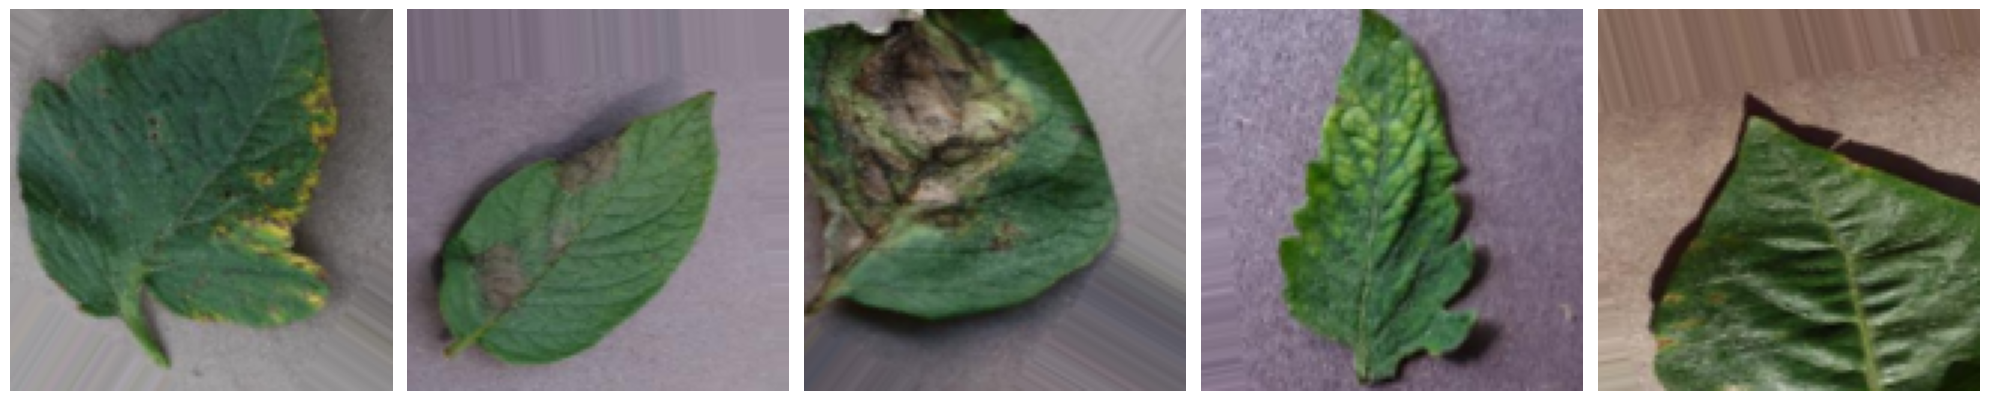

In [20]:
# Wählen Sie eine kleine Stichprobe von Bildern für die Demonstration
X_sample = X_train[:5]

# Erstellen eines Generators für die ausgewählten Beispiele
sample_generator = train_datagen.flow(X_sample, batch_size=1)

# Sammeln der augmentierten Bilder
augmented_images = [sample_generator.next()[0] for _ in range(5)]  # 5 augmentierte Bilder generieren

import matplotlib.pyplot as plt

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):

        # Da img durch rescale modifiziert wurde und matplotlib erwartet, dass die Daten im Bereich [0, 1] liegen,
        # ist keine weitere Anpassung der Bild-Daten notwendig.
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Aufrufen der Funktion mit den augmentierten Bildern
plot_images(augmented_images)


#**Data Modeling**

**Create 1st Model**





In [19]:
# Define the CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_cnn.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Anzahl der Schritte pro Epoche
    epochs=10,  # Anzahl der Epochen
    validation_data=validation_generator,
    validation_steps=len(X_valid) // 32  # Anzahl der Schritte pro Validierungsepoche
)


Epoch 1/10
227/227 [==============================] - 257s 1s/step - loss: 4.2952 - accuracy: 0.4015 - val_loss: 2.0633 - val_accuracy: 0.4208
Epoch 2/10
227/227 [==============================] - 252s 1s/step - loss: 1.3192 - accuracy: 0.5938 - val_loss: 1.0542 - val_accuracy: 0.6575
Epoch 3/10
227/227 [==============================] - 256s 1s/step - loss: 0.9446 - accuracy: 0.7002 - val_loss: 1.1400 - val_accuracy: 0.6483
Epoch 4/10
227/227 [==============================] - 252s 1s/step - loss: 0.6805 - accuracy: 0.7803 - val_loss: 0.7679 - val_accuracy: 0.7676
Epoch 5/10
227/227 [==============================] - 248s 1s/step - loss: 0.5042 - accuracy: 0.8357 - val_loss: 0.8962 - val_accuracy: 0.7246
Epoch 6/10
227/227 [==============================] - 251s 1s/step - loss: 0.3687 - accuracy: 0.8771 - val_loss: 0.8516 - val_accuracy: 0.7565
Epoch 7/10
227/227 [==============================] - 250s 1s/step - loss: 0.3108 - accuracy: 0.9047 - val_loss: 0.9757 - val_accuracy: 0.7551

In [ ]:
model_cnn.save('/content/drive/My Drive/model_cnn.h5')

**2nd Model**

A deeper model with differnet filter sizes and more layers.

In [ ]:
model_cnn2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn2.compile(optimizer=Adam(learning_rate=0.01, momentum=0.9),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
model_cnn2.summary()


**Create 3rd Model**

Different activation functions and dropout rates.

In [ ]:
model_cnn3 = Sequential([
    Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn3.compile(optimizer=SGD(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
model_cnn3.summary()
